# Example Notebook Running SPARCSpy on datasets with multiple images

The SPARCSpy base Project class is focused on processing whole slide images. In case you want to process Image Datasets with multiple-images then you will need to use the SPARCSpy TimecourseProject class and associated methods. This tutorial will walk you through this process.

In [2]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scportrait.pipeline.classification import CellFeaturizer
from scportrait.pipeline.extraction import TimecourseHDF5CellExtraction
from scportrait.pipeline.project import TimecourseProject
from scportrait.pipeline.workflows import Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation
from tqdm.notebook import tqdm

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some Helper Functions for visualization of results

In [4]:
from scportrait.processing.preprocessing import percentile_normalization


def plot_seg_overlay_timecourse(project_path, channel_to_show=0, seg_mask_to_show=0, selection=None, return_fig=False):
    seg_path = f"{project_path}/segmentation/input_segmentation.h5"
    with h5py.File(seg_path, "r") as hf:
        segmentation = hf.get("segmentation")
        channels = hf.get("input_images")

        print(segmentation)
        print(channels)

        if selection is None:
            segmentation = segmentation[0, seg_mask_to_show, :, :]
            image = channels[0, channel_to_show, :, :]

            fig = plt.figure()
            plt.imshow(percentile_normalization(image), cmap="Greys_r")
            plt.imshow(segmentation, alpha=0.5, cmap="jet")
            plt.axis("off")

        if return_fig:
            return fig


def visualize_single_cells(project_path, n_cells=10):
    cells_path = f"{project_path}/extraction/data/single_cells.h5"

    with h5py.File(cells_path, "r") as hf:
        cells = hf.get("single_cell_data")
        n_channels = cells.shape[1]

        fig, axs = plt.subplots(n_cells, n_channels, figsize=(n_channels * 1, n_cells * 1))

        for i in range(n_cells):
            image = cells[i]
            for n in range(n_channels):
                axs[i, n].imshow(image[n])
                axs[i, n].axis("off")

## Initialize a Project

SPARCSpy works with a project structure that is kept the same across different projects. Each project contains all of the results from one run. Each Project has the same general structure:

    .
    ├── classification
    │   └── classifier_name
    │       └── processing.log
    ├── config.yml
    ├── extraction
    ├── segmentation
    └── processing.log


At the beginning of a SPARCSpy analysis a new project is generated where configuration parameters are loaded from the config file. This determines how each processing step will be executed.Here is a minimal example including the different cellpose segmentation methods for TimecourseProjects.

    ----------------
    name: "HPA segmentation"
    input_channels: 3
    output_channels: 5 #always add 2 to the number of channels
    Multithreaded_Cytosol_Cellpose_TimecourseSegmentation:
        input_channels: 3
        output_masks: 2
        threads: 5 #the segmentation model is loaded for each segmentation process utilizing GPU memory. Depending on GPU size this needs to be adjusted
        cache: "." #path to where intermediate results are written to memory mapped temp arrays
        lower_quantile_normalization:   0.000
        upper_quantile_normalization:   1.000
        median_filter_size:   4 
        nucleus_segmentation:
            model: "nuclei"
            diameter: 400 #if this parameter is not set then cellpose will determine the diameter of the segemented shapes automatically
        cytosol_segmentation:
            model: "cyto2"
            diameter: 700
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False
    Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation:
        input_channels: 3
        output_masks: 2
        threads: 5
        cache: "."
        lower_quantile_normalization:   0.000
        upper_quantile_normalization:   1.000
        median_filter_size:   4 
        nucleus_segmentation:
            model: "nuclei"
        cytosol_segmentation:
            model: "cyto2"
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False
        downsampling_factor: 10 #downsamples images before performing segmentation, the segmented masks are upscaled again to the original dimension
        smoothing_kernel_size: 7
    Cytosol_Cellpose_Downsampling_TimecourseSegmentation:
        input_channels: 3
        output_masks: 2
        cache: "."
        lower_quantile_normalization:   0.000
        upper_quantile_normalization:   1.000
        median_filter_size:   4 
        nucleus_segmentation:
            model: "nuclei"
        cytosol_segmentation:
            model: "cyto2"
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False
        downsampling_factor: 10
        smoothing_kernel_size: 7
    TimecourseHDF5CellExtraction:
        compression: True
        threads: 8 # threads used in multithreading
        image_size: 512 # image size in pixel
        cache: "."
        hdf5_rdcc_nbytes: 5242880000 # 5gb 2048 * 2048 * 1250
        hdf5_rdcc_w0: 1
        hdf5_rdcc_nslots: 1250
    CellFeaturizer:
        channel_classification: 4
        threads: 20 
        batch_size: 100
        dataloader_worker_number: 5
        inference_device: "cuda"
        screen_label: "featurization_Ch4"
        

In [5]:
# initialize project
project_location = "project"

project = TimecourseProject(
    os.path.abspath(project_location),
    config_path="config_example6.yml",
    segmentation_f=Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation,
    extraction_f=TimecourseHDF5CellExtraction,
    classification_f=CellFeaturizer,
    overwrite=False,
    debug=False,
)

modifying config


## Input Data Format

SPARCSpy was optimized to work with Data generated using an Opera Phenix Microscope. Each Project class has several data_loader functions associated with it that can be used to load data from different sources. You can find the code under `src/sparcscore/project.py`. The Dataloaders that load images from files are optimzied for file_name notation generated by the Phenix and the associated processing scripts. 

Data Format for `load_input_from_files`:

    .... main directory
        - Row02_Well02_Row02_Well02
            - Timepoint001_Row02_Well02_Alexa488_zstack001Row02_Well02.tif
            - Timepoint001_Row02_Well02_mCherry_zstack001_r000_c000.tif
            - Timepoint001_Row02_Well02_DAPI_zstack001_r000_c000.tif
        - ...

Alternatively you can load data from a numpy array using `load_input_from_array` which can be used more flexibly to write your own dataloader:

- images needs to be supplied in the shape (N, C, X, Y) to the parameter img
- labels need to be supplied as a tidy dataframe to the parameter label. The first two columns of the dataframe need to contian the following information: row_index, unique Image ID. Then you can append as many additional labels as you want. 

Also feel free to submit a PR with a new dataloader for a common microscopy file format. Here we will demonstrate loading data using numpy to be more flexible to all data inputs.

## Example loading data via a numpy array

the timecourse SPARCSpy project expects images of the following format: NCYX.

All of the images need to have the same dimensions and the same number of channels. The channels should be in the following order: nucleus, cytosol, other channels. 

The images need to have the dtype uint16.

Here we have example code which reads RGB images (saved as PNGs), converts them to the expected format and loads them into a SPARCSpy timecourse project.

In [12]:
from scportrait.data._datasets import dataset_6

dataset_6_path = dataset_6()

# read metadata of images
metadata = pd.read_csv(f"{dataset_6_path}/metadata.csv", index_col=0)
metadata.head()

,gene_id,antibody,species,cell_line,organ,cellosaurusID,location,image_URL,image_location
0,ENSG00000000003,HPA004109,human,U2OS,Mesenchymal,CVCL_0042,cytosol,http://images.proteinatlas.org/4109/23_H11_1_b...,images/00005.jpg
1,ENSG00000000003,HPA004109,human,U2OS,Mesenchymal,CVCL_0042,cytosol,http://images.proteinatlas.org/4109/23_H11_2_b...,images/00006.jpg
2,ENSG00000000460,HPA024451,human,U2OS,Mesenchymal,CVCL_0042,NaN,http://images.proteinatlas.org/24451/226_G2_1_...,images/00017.jpg
3,ENSG00000000460,HPA024451,human,U2OS,Mesenchymal,CVCL_0042,NaN,http://images.proteinatlas.org/24451/226_G2_2_...,images/00018.jpg
4,ENSG00000000938,HPA002024,human,U2OS,Mesenchymal,CVCL_0042,plasma membrane,http://images.proteinatlas.org/2024/59_H5_1_bl...,images/00023.jpg


In [16]:
# read images
import platform
from multiprocessing import Pool, get_context

from skimage.transform import resize

image_paths = metadata["image_location"]
image_paths = [f"{dataset_6_path}/{path}" for path in image_paths]

# define a function to read the images, they need to be return as image stacks with each channel in a different dimension of the type np.uint16
def read_image(img):
    image = plt.imread(img)
    # convert from rgb to brg (nucleus, cytosol, other)
    image = np.roll(image, 1, 2)
    if image.shape[0] != 2048:
        image = resize(
            image, (2048, 2048)
        )  # some of the images have different shapes so we force resize of those images that dont match the most common shape

    # convert from H x W x C to C x H x W
    image = np.moveaxis(image, [2, 0, 1], [0, 1, 2])
    image = image.astype("float64")
    image = (image / image.max() * 65535).astype(
        "uint16"
    )  # normalize all images to the same range and then convert to uint16
    return image


context = "spawn" if platform.system() == "Windows" else "fork"

with get_context(context).Pool(processes=12) as pool:
    images = pool.map(read_image, image_paths)
    images = np.stack(images)

The images have the expected shape (10 images, 3 channels, 2048px, 2048px) and look as expected

(10, 3, 2048, 2048)
uint16


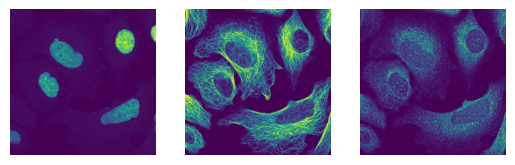

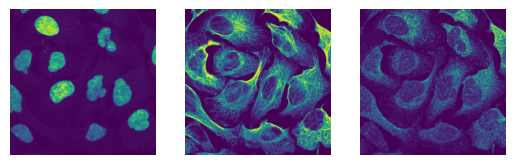

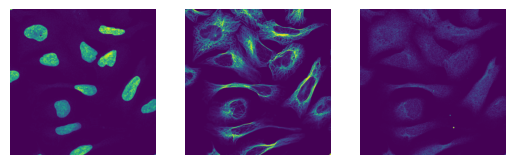

In [17]:
print(images.shape)
print(images.dtype)

for i in images[0:3]:
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(i[0])
    axs[0].axis("off")
    axs[1].imshow(i[1])
    axs[1].axis("off")
    axs[2].imshow(i[2])
    axs[2].axis("off")

In [18]:
# format the metadata to the expected format
metadata = metadata.reset_index()
metadata = metadata.get(
    ["index", "image_URL", "gene_id", "antibody", "species", "cell_line", "organ", "cellosaurusID"]
)  # here we use the image_URL as a unqiue image id

In [19]:
# load data into sparcspy
project.load_input_from_array(images, label=metadata, overwrite=True)

Images and labels are written to the `input_segmentation.h5` HDF5 file contained under segmentation in the project folder.
The input images are written to the container "input_images" and the labels to "labels". Column names are saved in a seperate dataset with the name "label_names".


In [20]:
with h5py.File(f"{project_location}/segmentation/input_segmentation.h5") as hf:
    print(hf.get("input_images"))
    print(hf.get("labels"))

    print("Example Label Dataset")
    print(hf.get("label_names")[:])
    print(hf.get("labels")[:])

<HDF5 dataset "input_images": shape (10, 3, 2048, 2048), type "<u2">
<HDF5 dataset "labels": shape (10, 8), type "|O">
Example Label Dataset
[b'index' b'image_URL' b'gene_id' b'antibody' b'species' b'cell_line'
 b'organ' b'cellosaurusID']
[[b'0' b'http://images.proteinatlas.org/4109/23_H11_1_blue_red_green.jpg'
  b'ENSG00000000003' b'HPA004109' b'human' b'U2OS' b'Mesenchymal'
  b'CVCL_0042']
 [b'1' b'http://images.proteinatlas.org/4109/23_H11_2_blue_red_green.jpg'
  b'ENSG00000000003' b'HPA004109' b'human' b'U2OS' b'Mesenchymal'
  b'CVCL_0042']
 [b'2'
  b'http://images.proteinatlas.org/24451/226_G2_1_blue_red_green.jpg'
  b'ENSG00000000460' b'HPA024451' b'human' b'U2OS' b'Mesenchymal'
  b'CVCL_0042']
 [b'3'
  b'http://images.proteinatlas.org/24451/226_G2_2_blue_red_green.jpg'
  b'ENSG00000000460' b'HPA024451' b'human' b'U2OS' b'Mesenchymal'
  b'CVCL_0042']
 [b'4' b'http://images.proteinatlas.org/2024/59_H5_1_blue_red_green.jpg'
  b'ENSG00000000938' b'HPA002024' b'human' b'U2OS' b'Mesen

## Segmentation

SPARCSpy has different segmentation workflows between which you can choose. If you run a timecourse project you will need to also select a timecourse segementation method. 

**notes on cellpose segmentation methods:**

Cellpose currently does not allow for the processing of image batches. Each image will thus be segmented individually on the GPU. In case you have large images this isnt an issue since the GPU is still fully utilzed (the sharding parameter can be used to set an optimal shard size for maximizing GPU utilization). For a large quantity of small images this leads to a very inefficient processing. To improve the speed a bit you can try running with multiple threads. Each thread will also load the model though so it requires quite some Memory overhead. This is hopefully an issue we can address in future releases. If its something you would like to work on get in touch with the developers we are happy for help!

In [21]:
project.segment(debug=True)

[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation_4yy8hcp5 for Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation


Generating Shards: 100%|██████████| 10/10 [00:00<00:00, 3209.11it/s]

[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_hk23a80l for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_n2a0kq_0 for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse__7e5yjw6 for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_1udqby1u for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:46] Initialized temporary directory at /var/folders/35/p4c58_4n3bb


  0%|          | 0/10 [00:00<?, ?it/s]

[27/01/2025 19:44:50] Segmentation on index 0 started.
[27/01/2025 19:44:50] Segmentation on index 1 started.
[27/01/2025 19:44:50] Segmentation on index 2 started.
[27/01/2025 19:44:50] Segmentation on index 3 started.
[27/01/2025 19:44:50] Segmentation on index 4 started.
[27/01/2025 19:44:50] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_9_k70_qs for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:50] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_ee9jbuz9 for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:50] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_a0c690rn for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:50] Initialized temp

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename,

[27/01/2025 19:44:51] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:44:51] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:44:51] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:44:51] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:44:51] Segmenting nucleus using the following model: nuclei


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for a

[27/01/2025 19:44:54] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:44:54] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:44:54] Removed 3 nuclei and 0 cytosols due to filtering.
[27/01/2025 19:44:54] After filtering, 11 matching nuclei and cytosol masks remain.
[27/01/2025 19:44:55] Total time to perform nucleus and cytosol mask matching filtering: 0.71 seconds


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for a

[27/01/2025 19:44:57] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:44:57] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:44:58] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:44:58] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:44:58] transferring 3 to temmporray memory mapped array
[27/01/2025 19:44:58] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_5ufap6ed'>
[27/01/2025 19:44:58] Temporary directory not found, skipping cleanup
[27/01/2025 19:44:58] Segmentation on index 3 completed.
[27/01/2025 19:44:58] Segmentation on index 5 started.
[27/01/2025 19:44:58] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_3wttq9z6 for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:44:58] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:44:58] Removed 5 nuclei and 3 cytosols due to filtering.
[27/01/2025 19:44:58] After filtering, 10 matching nuclei and cytosol masks remain.
[27/01/2025 19:44:58] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename,

[27/01/2025 19:44:58] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:44:59] Total time to perform nucleus and cytosol mask matching filtering: 1.08 seconds
[27/01/2025 19:44:59] Total time to perform nucleus and cytosol mask matching filtering: 1.06 seconds
[27/01/2025 19:44:59] Total time to perform nucleus and cytosol mask matching filtering: 1.09 seconds
[27/01/2025 19:44:59] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:44:59] Total time to perform nucleus and cytosol mask matching filtering: 1.08 seconds


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:45:00] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:45:00] Removed 3 nuclei and 5 cytosols due to filtering.
[27/01/2025 19:45:00] After filtering, 6 matching nuclei and cytosol masks remain.
[27/01/2025 19:45:00] Total time to perform nucleus and cytosol mask matching filtering: 0.40 seconds
[27/01/2025 19:45:02] transferring 4 to temmporray memory mapped array
[27/01/2025 19:45:02] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_7123qcfq'>
[27/01/2025 19:45:02] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:02] Segmentation on index 4 completed.
[27/01/2025 19:45:02] Segmentation on index 6 started.
[27/01/2025 19:45:02] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_7ipdauk_ for Cytosol_Segmentation_Downsampling_Cellpose_Ti

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename,

[27/01/2025 19:45:02] Downsampling image by a factor of 10x10
[27/01/2025 19:45:02] GPU Status for segmentation is True and will segment using the following device mps.
[27/01/2025 19:45:02] Performing image padding to ensure that image is compatible with selected downsample kernel size of 10.
[27/01/2025 19:45:02] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_9_k70_qs'>
[27/01/2025 19:45:02] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:02] Segmentation on index 0 completed.
[27/01/2025 19:45:02] Downsampling image by a factor of 10x10
[27/01/2025 19:45:02] Segmentation on index 9 started.
[27/01/2025 19:45:02] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_oueupeg5 for Cytosol_Segmentation_Downsampling_Cellpose_Timecourse
[27/01/2025 19:45:02] GPU Status for se

/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename,

[27/01/2025 19:45:02] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:45:02] Performing image padding to ensure that image is compatible with selected downsample kernel size of 10.
[27/01/2025 19:45:02] Downsampling image by a factor of 10x10
[27/01/2025 19:45:02] GPU Status for segmentation is True and will segment using the following device mps.
[27/01/2025 19:45:02] Segmenting nucleus using the following model: nuclei


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename,

[27/01/2025 19:45:03] transferring 5 to temmporray memory mapped array
[27/01/2025 19:45:03] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_3wttq9z6'>
[27/01/2025 19:45:03] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:03] Segmentation on index 5 completed.
[27/01/2025 19:45:03] Segmenting nucleus using the following model: nuclei
[27/01/2025 19:45:03] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:45:03] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:45:03] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:45:03] Segmenting cytosol using the following model: cyto2
[27/01/2025 19:45:03] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:45:03] Removed 1 nuclei and 2 cytosols due to filtering.
[27/01/2025 19:45:03] After filtering, 5 matching nuclei and cytosol masks remain.
[27/01/2025 19:45:03] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:45:03] Removed 1 nuclei and 0 cytosols due to filtering.
[27/01/2025 19:45:03] After filtering, 6 matching nuclei and cytosol masks remain.
[27/01/2025 19:45:03] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:45:03] Removed 3 nuclei and 0 cytosols due to filtering.
[27/01/2025 19:45:03] After filtering, 14 matching nuclei and cytosol masks remain.


/Users/sophia/mambaforge/envs/test/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:45:04] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:45:04] Total time to perform nucleus and cytosol mask matching filtering: 0.43 seconds
[27/01/2025 19:45:04] Removed 6 nuclei and 1 cytosols due to filtering.
[27/01/2025 19:45:04] After filtering, 11 matching nuclei and cytosol masks remain.
[27/01/2025 19:45:04] Total time to perform nucleus and cytosol mask matching filtering: 0.42 seconds
[27/01/2025 19:45:04] Total time to perform nucleus and cytosol mask matching filtering: 0.42 seconds
[27/01/2025 19:45:04] Total time to perform nucleus and cytosol mask matching filtering: 0.42 seconds


 80%|████████  | 8/10 [00:20<00:04,  2.01s/it]

[27/01/2025 19:45:06] transferring 7 to temmporray memory mapped array
[27/01/2025 19:45:06] transferring 6 to temmporray memory mapped array
[27/01/2025 19:45:06] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_uh58utop'>
[27/01/2025 19:45:06] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:06] Segmentation on index 7 completed.
[27/01/2025 19:45:06] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_7ipdauk_'>
[27/01/2025 19:45:06] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:06] Segmentation on index 6 completed.
[27/01/2025 19:45:06] transferring 8 to temmporray memory mapped array
[27/01/2025 19:45:06] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentatio

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

[27/01/2025 19:45:07] transferring 9 to temmporray memory mapped array
[27/01/2025 19:45:07] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Cytosol_Segmentation_Downsampling_Cellpose_Timecourse_oueupeg5'>
[27/01/2025 19:45:07] Temporary directory not found, skipping cleanup
[27/01/2025 19:45:07] Segmentation on index 9 completed.


All segmentations are done.
[27/01/2025 19:45:08] Finished parallel segmentation
[27/01/2025 19:45:08] Transferring results to array.
[27/01/2025 19:45:08] resolve segmentation indexes


Adjusting Indexes: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


[27/01/2025 19:45:10] Number of filtered classes combined after segmentation:
[27/01/2025 19:45:10] 77
[27/01/2025 19:45:10] Number of classes in contact with image edges:
[27/01/2025 19:45:10] 0
[27/01/2025 19:45:10] Number of classes after removing image edges:
[27/01/2025 19:45:10] 77
[27/01/2025 19:45:10] Saved cell_id classes to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_6/project/segmentation/classes.csv.
[27/01/2025 19:45:13] Sharding sanity check: edge classes are a full subset of all classes
[27/01/2025 19:45:13] resolved segmentation list
[27/01/2025 19:45:13] Adjusted Indexes.
[27/01/2025 19:45:13] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./Multithreaded_Cytosol_Cellpose_Downsampling_TimecourseSegmentation_4yy8hcp5'>


Segmentation results are written to the `input_segmentation.h5` HDF5 file in a new data container called "segmentation". 
In addition a csv file called classes.csv is generated which contains all the cell_ids that are not located in image edges and will be further processed.

If we look at the segmentation dataset we can see that it contains a numpy array containing two segmentation masks for each input image: the nuclear segmentation and the cytosol segmentation generated by our chosen segmentation method. If you use the method CytosolOnly both of the masks will be identical.

<HDF5 dataset "segmentation": shape (10, 2, 2048, 2048), type "<u8">
<HDF5 dataset "input_images": shape (10, 3, 2048, 2048), type "<u2">
<HDF5 dataset "segmentation": shape (10, 2, 2048, 2048), type "<u8">
<HDF5 dataset "input_images": shape (10, 3, 2048, 2048), type "<u2">
<HDF5 dataset "segmentation": shape (10, 2, 2048, 2048), type "<u8">
<HDF5 dataset "input_images": shape (10, 3, 2048, 2048), type "<u2">
<HDF5 dataset "segmentation": shape (10, 2, 2048, 2048), type "<u8">
<HDF5 dataset "input_images": shape (10, 3, 2048, 2048), type "<u2">


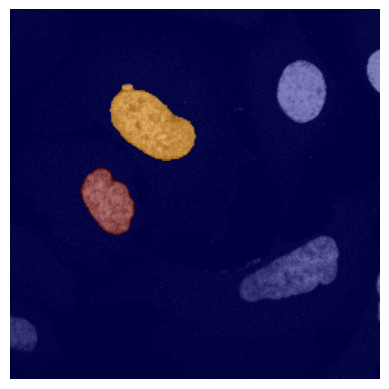

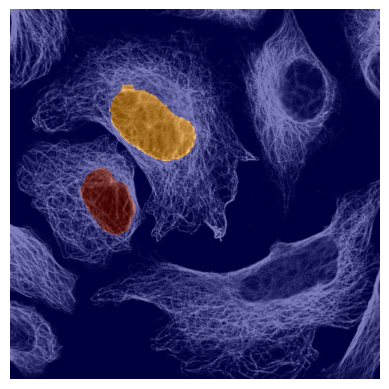

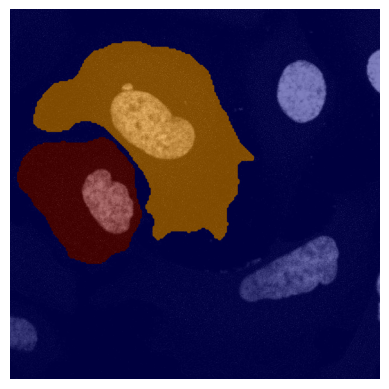

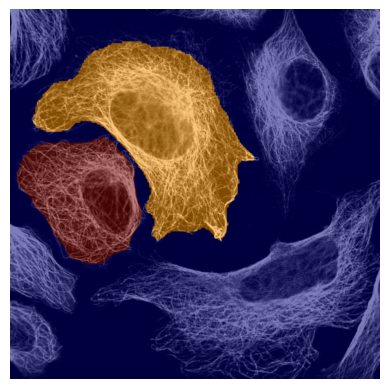

In [22]:
plot_seg_overlay_timecourse(project_location, channel_to_show=0)
plot_seg_overlay_timecourse(project_location, channel_to_show=1)

plot_seg_overlay_timecourse(project_location, channel_to_show=0, seg_mask_to_show=1)
plot_seg_overlay_timecourse(project_location, channel_to_show=1, seg_mask_to_show=1)

## Single-Cell Extraction

In [23]:
project.extract()

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


The extracted single-cell images are written to a h5py file single_cells.h5 located under `extraction\data` within the project folder.

The file contains four datasets: `single_cell_data`, `single_cell_index`, `single_cell_index_labelled`, `label_names`. 

`single_cell_data` contains the extracted single cell images while `single_cell_index` contains the cell id of the extracted cell at that location.

The other two datacontainers integrated the labels from the base dataset and attach them to each cell.

In [24]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf.keys())

    print(hf.get("label_names")[:])
    print(hf.get("single_cell_index_labelled")[2])

<KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>
[b'index' b'cellid' b'image_URL' b'gene_id' b'antibody' b'species'
 b'cell_line' b'organ' b'cellosaurusID']
[b'12' b'http://images.proteinatlas.org/4109/23_H11_2_blue_red_green.jpg'
 b'ENSG00000000003' b'HPA004109' b'human' b'U2OS' b'Mesenchymal'
 b'CVCL_0042']


In [25]:
# single cell index contains two columns, the first is the index position in the hdf5 datacontainer, the second is the cell id

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    # print(hf["single_cell_index"][0:10])
    print(hf["single_cell_index"][2])

[ 2 12]


In [26]:
# single cell index labelled contains the same information as single_cell_index
# in the first two columns but adds additional columns with labelling information, the column names for
# the labelling information is contained in label_names

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf["label_names"][:])
    print(hf["single_cell_index_labelled"][2])

[b'index' b'cellid' b'image_URL' b'gene_id' b'antibody' b'species'
 b'cell_line' b'organ' b'cellosaurusID']
[b'12' b'http://images.proteinatlas.org/4109/23_H11_2_blue_red_green.jpg'
 b'ENSG00000000003' b'HPA004109' b'human' b'U2OS' b'Mesenchymal'
 b'CVCL_0042']


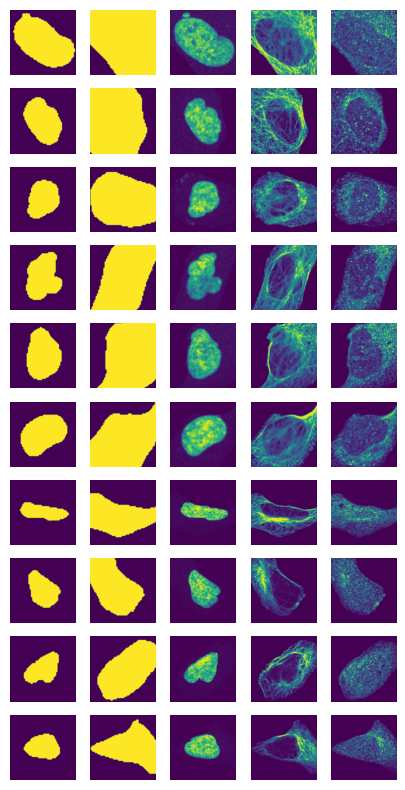

In [27]:
visualize_single_cells(project_location)